#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

In [2]:
YEAR = 2011

# OCR with Adobe Acrobat and extraction with fitz

In [3]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

### Extract text

In [4]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_{}.pdf".format(YEAR))
print('Number of pages:', len(doc))

Number of pages: 715


In [5]:
def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    text_by_row = []
    temp = []
    init_y = text[0][1] #y0
    i = 0
    while i < len(text):
        if (text[i][1] < init_y + threshold) and (text[i][1] > init_y - threshold):
            temp.append(text[i][4])
        else:
            text_by_row.append(temp)
            temp = [text[i][4]]
            init_y = int(text[i][1])
        i += 1
    text_by_row.append(temp)
    return text_by_row

- Extract keys

In [21]:
abbr_keys = {}

In [22]:
#keys for treatment
pagen = 5
words = doc[pagen - 1].getText("words")
words = text_to_rows(words, 5)[3:-2]
for line in words:
    if re.match(r'(?:[A-Z-]+)$', line[0]):
        abbr_keys[line[0]] = ' '.join(line[1:])

In [23]:
#keys for language
pagen = 6
words = doc[pagen - 1].getText("words")
page6 = text_to_rows(words, 5)

In [24]:
for line in page6:
    if (line[0][0] == 'N' or line[0][0] == 'F') and line[0][1].isnumeric():
        #print(line)
        abbr_keys[line[0]] = line[1]

In [68]:
# abbr_keys['SF'] = 'Self payment'
# abbr_keys['N35'] = None
# abbr_keys['F67'] = None

In [46]:
#add keys that not included in front pages but exists in other pages

In [47]:
# for i in range(1, 46):
#     if 'N' + str(i) not in abbr_keys:
#         abbr_keys['N' + str(i)] = None
#         print('N' + str(i))

In [48]:
# for i in range(1, 103):
#     if 'F' + str(i) not in abbr_keys:
#         abbr_keys['F' + str(i)] = None
#         print('F' + str(i))

In [47]:
abbr_keys['F67'] = None

In [49]:
len(abbr_keys)

129

In [50]:
#save dictionary
import numpy as np
np.save('keys.npy'.format(YEAR), abbr_keys) 

- Explore text

In [27]:
# - explore the page set up - 
# select a page
firstpagen = 17
words = doc[firstpagen - 1].getText("words")

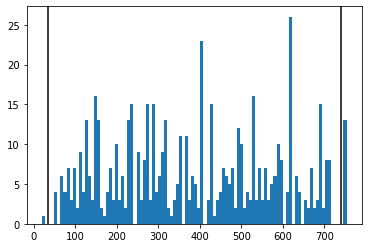

In [28]:
# check the y distribution to remove top and bottom crap...
y0s = [word[1] for word in words]
a = plt.hist(y0s, bins = 100)
plt.axvline(35, color='black')
plt.axvline(740, color='black')

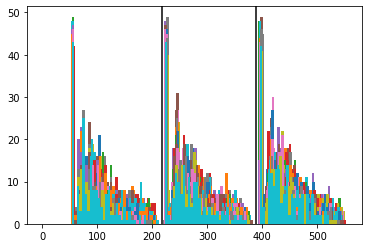

In [29]:
#to find column seperation
for pagen in range(100, 200):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if word[1] > 35]
    words = [word for word in words if word[1] < 740]
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 100)
    
plt.axvline(218, color='black')
plt.axvline(388, color='black')

- Read text from PDF

In [30]:
def get_words_in_box(page, ulim, blim, col1lim, col2lim):
    '''
    Extract words from each column of the PDF.
    '''
    page_txt = []
    words = page.getText("words") 
    #cut off top and bottom
    words = [word for word in words if word[1] > ulim]
    words = [word for word in words if word[1] < blim]
    #get three columns
    page_txt.append(text_to_rows([word for word in words if word[0] < col1lim], 5))
    page_txt.append(text_to_rows([word for word in words if ((word[0] > col1lim) and (word[0] < col2lim))], 5))
    page_txt.append(text_to_rows([word for word in words if word[0] > col2lim], 5))
    return page_txt

In [31]:
#testing
get_words_in_box(doc[firstpagen - 1], 35, 740, 217, 388)
#page with some blanck
#get_words_in_box(doc[24 - 1], 35, 740, 217, 388)

[[['ABBEVILLE'],
  ['SpectraCare'],
  ['Henry', 'Co', 'IOP'],
  ['219', 'Dothan', 'Road'],
  ['Abbeville,', 'AL', '36310'],
  ['(334)', '673-2143'],
  ['Hotline:', '(800)', '951-4357'],
  ['SA',
   '\uf073',
   'TX',
   '\uf073',
   'OP',
   '\uf073',
   'SF',
   'MD',
   'SI',
   'PI',
   'MI',
   '\uf073',
   'AH'],
  ['ALABASTER'],
  ['Shelby', 'County', 'Treatment', 'Center'],
  ['750', 'Highway', '31', 'South'],
  ['Alabaster,', 'AL', '35007'],
  ['(205)', '216-0200'],
  ['Intake:', '(205)', '216-0202'],
  ['Hotlines:', '(888)', '950-4325', '(888)', '950HEAL'],
  ['Methadone', 'and', 'Buprenorphine', 'Clients', 'Only'],
  ['SA',
   '\uf073',
   'TX',
   'MM',
   'BU',
   '\uf073',
   'OP',
   'PH',
   '\uf073',
   'CO',
   'HV',
   'GL'],
  ['SE',
   'PW',
   'WN',
   'MN',
   'DU',
   'CJ',
   '\uf073',
   'SF',
   'MD',
   'PI',
   '\uf073',
   'AH'],
  ['SP'],
  ['ALEXANDER', 'CITY'],
  ['Lighthouse', 'of', 'Tallapoosa', 'County', 'Inc'],
  ['Substance', 'Abuse', 'Rehab', 'Prog

In [42]:
#run
data = []
for pagen in range(firstpagen, len(doc) + 1):
    data.append(get_words_in_box(doc[pagen-1], 35, 740, 217, 388))

# Write data into csv

- Checking + cleaning each part of data

In [33]:
def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    '''
    line = [key for key in line if (key != '\uf073')]
    if not any(x not in abbr_keys for x in line):
        return True
    if line[0] in abbr_keys:
        if len(line) > 2 and line[1] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
        if len(line) > 3 and line[2] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
    return False

def clean_keys(line):
    return '/'.join([key for key in line if (key != '\uf073')]) + '/'

In [35]:
#is_keys(['SA', '\uf073', 'TX', 'HH', '\uf073', 'RL', '\uf073', 'MN', '\uf073', 'SF'])

In [36]:
#['Nogales,', 'AZ', '85621']
#['Chesapeake', 'Beach,', 'MD', '20732']
def is_citystatezip(line):
    if line[-1].isnumeric() and len(line[-1]) == 5 and line[-2].isupper() and len(line[-2]) == 2 and line[-3][-1] == ',':
        return True
    return False

def clean_citystatezip(line):
    return [' '.join(line[:-2])[:-1], line[-2], line[-1]]

In [37]:
#['(205)', '216-0200'],
#['Intake:', '(205)', '216-0202'],
#['Hotlines:', '(888)', '950-4325', '(888)', '950HEAL']
#['6552x']
#[261-8850x40]
#['942-2110x612']
def is_contact(line):
    if line[0] == 'Intake:' or line[0] == 'Intakes:' or line[0] == 'Hotline:'or line[0] == 'Hotlines:':
        return True
    if len(line[0]) < 5:
        return False
    if line[0][0] == '(' and line[0][4] == ')' and line[0][1:4].isnumeric():
        return True
    if line[0][:4].isnumeric() and line[0][4] == 'x':
        return True
    if len(line[0]) > 10 and line[0][4:8].isnumeric() and line[0][8] == 'x' and line[0][3] == '-':
        return True
    return False

def clean_contact(line):
    l = ''
    for word in line:
        if len(word) == 5 and word[0] == '(':
            l += word
        else:
            l += word + ' '
    return l.strip()

In [38]:
address_indicators = ['P.0.', 'P.O', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'Suite', 'Suites', 'Drive', 'Boulevard', \
                      'Annex', 'Streets','Floor', 'Fl', 'Bldg', 'Rear', 'Room', 'Basement', 'Building,', 'Attn:', 'HC-72'] ##
name_indicators = ['Clinic', 'Medical', 'Inc', 'Health', 'Services', 'Treatment']

def is_address(line):
    if (not line[0].replace('-', '').isnumeric()) and any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

In [39]:
# #for testing
# for page_data in data:
#     for col in page_data:
#         for line in col:
#             for word in line:
#                 if word[0] == 'F' and word[-1].isnumeric() and word not in abbr_keys:
#                     print(line)

- Split data into MOUDs

In [40]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    while i < len(col_text) - 1:
        if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
            temp.append(col_text[i])
            col_text_splitted.append(temp)
            temp = []
        elif is_keys(col_text[i]) and (is_keys(col_text[i+1])):
            temp.append(col_text[i])
        else:
            if (not re.match(r'(?:[A-Z]+)$', ''.join(col_text[i]))):
                #if not keys and only upper characters, then ignore as name of city.
                temp.append(col_text[i])
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

In [43]:
split_col_data(data[2][2])

[[['Cedar', 'Lodge'],
  ['A', 'Program', 'of', 'MLBH'],
  ['22165', 'U.S.', 'Highway', '431'],
  ['Guntersville,', 'AL', '35976'],
  ['(256)', '582-4465'],
  ['Intakes:', '(256)', '582-4465x100', '(256)', '582-'],
  ['4452x100'],
  ['Hotlines:', '(256)', '582-4465x100', '(256)', '582-5339'],
  ['SA',
   '\uf073',
   'TX',
   '\uf073',
   'RS',
   'OP',
   '\uf073',
   'WN',
   'MN',
   '\uf073',
   'SF',
   'MD',
   'SI'],
  ['PI', 'MI', '\uf073', 'SS', '\uf073', 'AH']],
 [['Family', 'Life', 'Center'],
  ['432', 'Gunter', 'Avenue'],
  ['Guntersville,', 'AL', '35976'],
  ['(256)', '582-1471'],
  ['MH-SA', '\uf073', 'TX', '\uf073', 'OP', '\uf073', 'SF', '\uf073', 'SS']],
 [['Marion', 'County', 'Treatment', 'Center'],
  ['1879', 'Military', 'Street', 'South'],
  ['Hamilton,', 'AL', '35570'],
  ['(205)', '921-3799'],
  ['Methadone', 'and', 'Buprenorphine', 'Clients', 'Only'],
  ['SA',
   '\uf073',
   'TX',
   'MM',
   'BU',
   '\uf073',
   'OP',
   '\uf073',
   'PW',
   'WN',
   'MN',
   '

- Write data

In [44]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('') 
            #name3
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not is_keys(facil[i]):##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
                while i < len(facil):
                    if is_contact(facil[i]):
                        data_holder[-1] += ' ' + clean_contact(facil[i])
                        i += 1
                    else:
                        break
            else:
                data_holder.append('')
            if i < len(facil):#might not have keys
                #website
                if facil[i][0].split('.')[-1] == 'org' or facil[i][0].split('.')[0] == 'www' or facil[i][0].split('.')[-1] == 'com':
                    data_holder.append(' '.join(facil[i]))
                    i += 1
                else:
                    data_holder.append('')
                #note
                if not is_keys(facil[i]):
                    data_holder.append(' '.join(facil[i]))
                    i += 1
                else:
                    data_holder.append('')
                #keys
                data_holder.append('')
                for keys in facil[i:]:
                    data_holder[-1] += clean_keys(keys)
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [51]:
filename = "{}.csv".format(YEAR)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", 'Name3', "Address1", "Address2", "Address3", "City", "State", "ZIP_Code", "Contact", "Website", "Note", "Keys"])

In [52]:
pagen = firstpagen

for page in data:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        if col != []:
            page_data_holders += clean_col_data(split_col_data(col))
            print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 17...... Finished Col ....... Finished Col ...... Finished Col 
Page: 18....... Finished Col ...... Finished Col ..... Finished Col 
Page: 19...... Finished Col ...... Finished Col ..... Finished Col 
Page: 20...... Finished Col ..... Finished Col ...... Finished Col 
Page: 21..... Finished Col ..... Finished Col ..... Finished Col 
Page: 22..... Finished Col .... Finished Col 
Page: 23...... Finished Col ...... Finished Col ...... Finished Col 
Page: 24..... Finished Col ..... Finished Col ...... Finished Col 
Page: 25...... Finished Col ...... Finished Col ...... Finished Col 
Page: 26..... Finished Col 
Page: 27...... Finished Col ..... Finished Col ...... Finished Col 
Page: 28..... Finished Col ..... Finished Col ...... Finished Col 
Page: 29...... Finished Col ...... Finished Col ...... Finished Col 
Page: 30..... Finished Col ...... Finished Col ...... Finished Col 
Page: 31...... Finished Col ...... Finished Col ...... Finished Col 
Page: 32...... Finished Col ...... Fini

In [70]:
# #check error data
#split_col_data(data[686-15][3-1])[5]

- Rewrite data in problem pages

In [71]:
# ^^

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [53]:
import pandas as pd

In [54]:
df = pd.read_csv("{}.csv".format(YEAR))
df

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Website,Note,Keys
0,SpectraCare,Henry Co IOP,NaN,219 Dothan Road,NaN,NaN,Abbeville,AL,36310,(334)673-2143 Hotline: (800)951-4357,NaN,NaN,SA/TX/OP/SF/MD/SI/PI/MI/AH/
1,Shelby County Treatment Center,NaN,NaN,750 Highway 31 South,NaN,NaN,Alabaster,AL,35007,(205)216-0200 Intake: (205)216-0202 Hotlines: ...,NaN,Methadone and Buprenorphine Clients Only,SA/TX/MM/BU/OP/PH/CO/HV/GL/SE/PW/WN/MN/DU/CJ/S...
2,Lighthouse of Tallapoosa County Inc,Substance Abuse Rehab Program/Resid,NaN,36 Franklin Street,NaN,NaN,Alexander City,AL,35010,(256)234-4894,NaN,NaN,SA/TX/HH/RL/MN/SF/
3,Anniston Fellowship House Inc,NaN,NaN,106 East 22nd Street,NaN,NaN,Anniston,AL,36201,(256)236-7229,NaN,NaN,SA/TX/HH/RL/MN/SF/
4,Bradford Health Services,Anniston Regional Office,NaN,826 Leighton Avenue,NaN,NaN,Anniston,AL,36207,(256)237-4209,NaN,NaN,SA/TX/OP/AD/SF/PI/
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11273,Volunteers of America,The Gathering Place,NaN,360 College Meadows Drive,NaN,NaN,Sheridan,WY,82801,(307)673-2510,NaN,NaN,SA/TX/DT/HH/RS/RL/OP/CO/HV/GL/SE/PW/WN/BC/DU/C...
11274,Volunteers of America,WYSTAR Outpatient and Men Residential,NaN,1095 Saberton Street,NaN,NaN,Sheridan,WY,82801,(307)672-2044,NaN,NaN,SA/TX/DT/HH/RS/RL/MN/CJ/SF/MD/SI/PI/MI/AR/
11275,Hot Springs County Counseling Service,NaN,NaN,121 South 4th Street,NaN,NaN,Thermopolis,WY,82443,(307)864-3138 Intake: (307)864-2247,NaN,NaN,MH-SA/TX/OP/DU/SF/MD/SI/PI/MI/AR/SS/PA/
11276,Peak Wellness Center,Goshen County Clinic,NaN,501 Albany Avenue,NaN,NaN,Torrington,WY,82240,(307)532-4091 Hotline: (307)532-4091,NaN,NaN,MH-SA/TX/OP/AD/WN/MN/DU/SF/MD/MC/PI/MI/SS/PA/A...


In [55]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[7])!=2:
        print(index)

In [56]:
#check if all zip codes are correct
df.dtypes

Name1        object
Name2        object
Name3        object
Address1     object
Address2     object
Address3     object
City         object
State        object
ZIP_Code      int64
Contact      object
Website     float64
Note         object
Keys         object
dtype: object

- Correct in Pandas

In [57]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'and' or row[0].split()[-1] == 'to':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [128]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [58]:
df.to_csv('{}_c.csv'.format(YEAR), index = False)